<a href="https://colab.research.google.com/github/kevinhoxha/FPL-Machine-Learning/blob/master/FPL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from keras import models
from keras import layers
from keras import losses
from keras import metrics
from keras import optimizers
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def drop_non_features(dfs, columns):
  for df in dfs:
    for col in columns:
      df.drop(col, axis=1, inplace=True)

def normalize_feature(train_df, test_df, feature):
  mean = train_df[feature].mean(axis=0)
  std = train_df[feature].std(axis=0)
  train_df[feature] -= mean
  train_df[feature] /= std
  test_df[feature] -= mean
  test_df[feature] /= std

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_df.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

train_url = 'https://github.com/kevinhoxha/FPL-Machine-Learning/blob/master/data/training/ma6_train.csv?raw=true'
test_url = 'https://github.com/kevinhoxha/FPL-Machine-Learning/blob/master/data/training/ma6_test.csv?raw=true'
raw_train_df = pd.read_csv(train_url, error_bad_lines=True, skiprows=0)
raw_test_df = pd.read_csv(test_url, error_bad_lines=True, skiprows=0)

In [3]:
train_df = raw_train_df[raw_train_df.avg_minutes > 0.0] #remove players on the bench
test_df = raw_test_df[raw_test_df.avg_minutes > 0.0] #remove players on the bench

train_df = train_df[train_df.position > 3.0] #remove defenders and goalies
test_df = test_df[test_df.position > 3.0] #remove defenders and goalies

drop_non_features([train_df, test_df], ["avg_ict_index", "avg_bonus", "avg_opponent_team", "avg_value", "position"
#"avg_assists", "avg_bps",	"avg_clean_sheets",	"avg_creativity",	"avg_goals_conceded",	"avg_goals_scored",	"avg_influence",	
#"avg_minutes",	"avg_own_goals",	"avg_penalties_missed",	"avg_penalties_saved",	"avg_red_cards",	"avg_saves",	"avg_threat",	
#"avg_total_points",	"was_home",	"avg_yellow_cards"
])

normalize_feature(train_df, test_df, "avg_bps")
normalize_feature(train_df, test_df, "avg_creativity")
normalize_feature(train_df, test_df, "avg_influence")
normalize_feature(train_df, test_df, "avg_threat")
normalize_feature(train_df, test_df, "avg_total_points")
train_df["avg_minutes"] /= 90
test_df["avg_minutes"] /= 90

train_target = train_df.pop("actual_points")
test_target = test_df.pop("actual_points")

train_df

,avg_assists,avg_bps,avg_clean_sheets,avg_creativity,avg_goals_conceded,avg_goals_scored,avg_influence,avg_minutes,avg_own_goals,avg_penalties_missed,avg_penalties_saved,avg_red_cards,avg_saves,avg_threat,avg_total_points,was_home,avg_yellow_cards
0,0.000000,0.270758,0.166667,-0.164261,0.666667,0.333333,0.198108,0.368519,0.0,0.0,0.0,0.0,0.0,0.506141,0.275005,1.0,0.0
1,0.333333,0.728660,0.166667,-0.159361,0.833333,0.333333,0.194967,0.470370,0.0,0.0,0.0,0.0,0.0,0.526901,0.876152,1.0,0.0
2,0.333333,0.619636,0.333333,-0.110361,1.000000,0.333333,0.147842,0.662963,0.0,0.0,0.0,0.0,0.0,0.641086,0.962030,1.0,0.0
3,0.333333,0.576026,0.333333,-0.125061,0.833333,0.333333,0.144700,0.616667,0.0,0.0,0.0,0.0,0.0,0.641086,0.876152,0.0,0.0
4,0.333333,-0.601435,0.166667,-0.666510,1.166667,0.000000,-0.939175,0.609259,0.0,0.0,0.0,0.0,0.0,-0.293149,-0.068507,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32730,0.000000,-0.775874,0.000000,-0.860059,0.500000,0.000000,-0.860634,0.185185,0.0,0.0,0.0,0.0,0.0,-1.227384,-1.013166,0.0,0.0
32731,0.000000,-0.775874,0.000000,-0.860059,0.500000,0.000000,-0.860634,0.185185,0.0,0.0,0.0,0.0,0.0,-1.227384,-1.013166,1.0,0.0
32732,0.000000,-0.841288,0.000000,-0.879659,0.500000,0.000000,-0.926609,0.166667,0.0,0.0,0.0,0.0,0.0,-1.227384,-1.099045,0.0,0.0
32733,0.000000,-0.841288,0.000000,-0.879659,0.500000,0.000000,-0.926609,0.166667,0.0,0.0,0.0,0.0,0.0,-1.227384,-1.099045,1.0,0.0


In [4]:
model = build_model()
history = model.fit(train_df.values, train_target.values,
                    epochs=16, batch_size=64,
                    validation_data=(test_df.values, test_target.values), verbose=0)

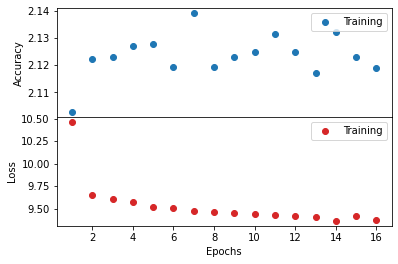

In [5]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
mae_values = history_dict['mae']
val_mae_values = history_dict['val_mae']

epochs = range(1, len(mae_values) + 1)

fig, axs = plt.subplots(2, sharex=True, sharey=False, gridspec_kw={'hspace': 0})

color = 'tab:red'
axs[1].plot(epochs, loss_values, 'bo', label='Training', color=color)
#axs[1].plot(epochs, val_loss_values, 'b', label='Validation', color=color)
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epochs')
axs[1].legend()

color = 'tab:blue'
axs[0].plot(epochs, mae_values, 'bo', label='Training', color=color)
#axs[0].plot(epochs, val_mae_values, 'b', label='Validation', color=color)
axs[0].set_ylabel('Accuracy')
axs[0].legend()

plt.show()


In [6]:
start = 1000
end = 1005
print(model.predict(train_df[start:end]))
print(train_target[start:end])

[[1.88728  ]
 [1.6530323]
 [1.1833372]
 [0.986943 ]
 [1.7707446]]
9120    0.0
9121    1.0
9122    1.0
9123    5.0
9124    5.0
Name: actual_points, dtype: float64
